# Differentiable Agent-Based Modeling of Macroeconomic Regimes

This notebook develops a differentiable ABM that simulates macroeconomic behavior under varying structural regimes. Using the latent macroeconomic factor (PC1) and regime labels extracted in the previous notebook, we construct a learning-based simulation in which heterogeneous agents interact with a simplified macroeconomic environment. The goal is to jointly optimize agent policy parameters and the macro-level outputs they produce, so that simulated dynamics align with historical macro factor trajectories and regime classifications.

We frame this task as a supervised learning problem with differentiable components: agents observe macroeconomic signals (PC1 and regime) and choose actions (e.g., consumption, savings, or labor supply) through learnable policy functions. These actions aggregate to generate a simulated macro factor, which is compared against actual PC1 via a loss function.

This framework offers a foundation for hybrid macroeconomic modeling—combining the interpretability of agent-based design with the adaptability of deep learning. The trained model can be used to explore regime-sensitive behavior, generate synthetic macro series, and serve as an engine for downstream forecasting or policy simulation.

In [1]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Data Prep

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

factor_df = pd.read_csv("/content/drive/MyDrive/macro_factor.csv", parse_dates=["Date"], index_col="Date")
regime_df = pd.read_csv("/content/drive/MyDrive/macro_regime.csv", parse_dates=["Date"], index_col="Date")

df = factor_df.join(regime_df, how="inner")

scaler = StandardScaler()
df["PC1_norm"] = scaler.fit_transform(df[["PC1"]])

# One-hot encode regime labels
encoder = OneHotEncoder(sparse_output=False)
regime_ohe = encoder.fit_transform(df[["Regime"]])
regime_labels = encoder.categories_[0]
regime_encoded_df = pd.DataFrame(regime_ohe, columns=[f"Regime_{int(i)}" for i in regime_labels], index=df.index)
df = df.join(regime_encoded_df)

window_size = 12
X_sequences = []
y_sequences = []
for i in range(window_size, len(df)):
    X_seq = df.iloc[i - window_size:i][["PC1_norm"] + list(regime_encoded_df.columns)].values
    y_seq = df.iloc[i][["PC1_norm"]].values  # target is next-month PC1
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print(f"Input sequence shape: {X_sequences.shape}")
print(f"Target shape: {y_sequences.shape}")

Input sequence shape: (84, 12, 4)
Target shape: (84, 1)


#Architecture of ABM:

- **Each agent** is a small GRU-based policy network.
- **Input**: Each agent observes the last 12 months of features: `[PC1_norm, Regime_0, Regime_1, Regime_2]`.
- **Output**: Each agent emits a scalar “action,” interpreted as its individual forecast for future PC1.
- **Aggregation**: The macro forecast is computed as the mean of all agent actions.
- **Classification**: A separate head uses the aggregated agent states to classify the next-month regime.

The model is fully differentiable, which allows us to train it end-to-end using gradient descent. We simultaneously minimize two objectives:

1. MSE between the predicted PC1 and the actual PC1.
2. Cross-entropy loss on the regime label to classify the next macro regime.

This joint training approach encourages agents to learn individual strategies that contribute both to accurate forecasting and regime-aware macro reasoning.

In [3]:
import torch
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
#@title Agent definition
class ABMAgent(nn.Module):
    """A single agent with its own GRUCell and policy head."""
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.gru = nn.GRUCell(input_dim, hidden_dim)
        self.policy = nn.Linear(hidden_dim, 1)

    def forward(self, x_t, h_t):
        h_next = self.gru(x_t, h_t)
        action  = self.policy(h_next)
        return action, h_next

In [6]:
class DifferentiableABM(nn.Module):
    def __init__(self,
                 input_dim: int = 4,
                 hidden_dim: int = 32,
                 n_agents: int = 20):
        super().__init__()
        self.n_agents = n_agents

        self.agents = nn.ModuleList(
            [ABMAgent(input_dim, hidden_dim) for _ in range(n_agents)]
        )

        self.global_mlp = nn.Sequential(
            nn.Linear(n_agents, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x_seq):
        B, T, F = x_seq.shape
        device  = x_seq.device

        h = [torch.zeros(B, agent.gru.hidden_size, device=device)
             for agent in self.agents]

        for t in range(T):
            x_t = x_seq[:, t, :]
            actions = []
            for i, agent in enumerate(self.agents):
                act, h_i = agent(x_t, h[i])
                h[i] = h_i
                actions.append(act)

            A_t = torch.cat(actions, dim=1)

        pc1_hat = self.global_mlp(A_t)

        h_stack = torch.stack(h, dim=0)
        h_mean  = h_stack.mean(dim=0)
        regime_logits = self.classifier(h_mean)

        return pc1_hat.squeeze(-1), regime_logits


In [8]:
model = DifferentiableABM().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss   = nn.MSELoss()
ce_loss    = nn.CrossEntropyLoss()

def train_step(X_batch, y_pc1, y_regime):
    model.train()
    optimizer.zero_grad()

    pc1_pred, regime_logits = model(X_batch)

    loss_pc1 = mse_loss(pc1_pred, y_pc1.squeeze(-1))
    loss_reg = ce_loss(regime_logits, y_regime)
    loss = loss_pc1 + 0.1 * loss_reg

    loss.backward()
    optimizer.step()
    return loss.item()

**Simulation engine**

We walk forward through the entire macro history, feeding the trained ABM a rolling 12-month window and recording its one-step-ahead forecast of PC1. We then compare those forecasts with the true PC1 to get an RMSE.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

FEATURES   = ["PC1_norm", "Regime_0", "Regime_1", "Regime_2"]
WINDOW     = 12

def make_window(idx: int):
    seq = df.iloc[idx-WINDOW:idx][FEATURES].values
    return torch.tensor(seq, dtype=torch.float32, device=DEVICE).unsqueeze(0)

@torch.no_grad()
def simulate_abm(start: int = WINDOW):
    model.eval()
    preds, truths = [], []

    for t in range(start, len(df)):
        X = make_window(t)
        pc1_pred, _ = model(X)
        preds.append(pc1_pred.item())
        truths.append(df.iloc[t]["PC1_norm"])

    return np.array(truths), np.array(preds)

**Training Loop**

Our training loop combines MSE loss on next-month PC1 and cross-entropy loss on next-month regime. These are our primary target and auxiliary target, respectively.

In [13]:
from torch.utils.data import TensorDataset, DataLoader

X_t   = torch.tensor(X_sequences,  dtype=torch.float32)
y_pc1 = torch.tensor(y_sequences, dtype=torch.float32)
y_reg = torch.tensor(df["Regime"].values[WINDOW:], dtype=torch.long)

dataset = TensorDataset(X_t, y_pc1, y_reg)
loader  = DataLoader(dataset, batch_size=16, shuffle=True)

n_epochs = 50
loss_history = []

for epoch in range(1, n_epochs + 1):
    batch_losses = []
    for Xb, yb_pc1, yb_reg in loader:
        Xb, yb_pc1, yb_reg = Xb.to(DEVICE), yb_pc1.to(DEVICE), yb_reg.to(DEVICE)
        batch_loss = train_step(Xb, yb_pc1, yb_reg)
        batch_losses.append(batch_loss)

    epoch_loss = np.mean(batch_losses)
    loss_history.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | mean batch loss {epoch_loss:.4f}")

Epoch  50 | mean batch loss 0.0326


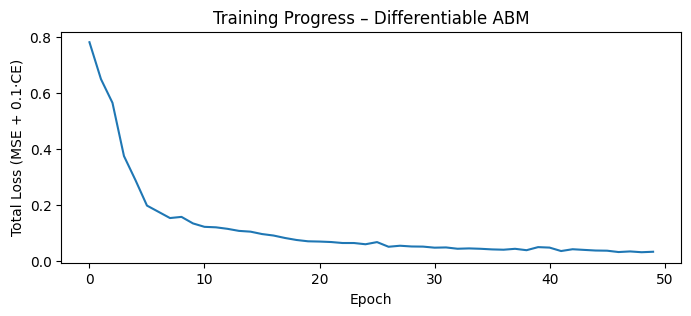

In [17]:
plt.figure(figsize=(8,3))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Total Loss (MSE + 0.1·CE)")
plt.title("Training Progress – Differentiable ABM")
plt.show()

In [15]:
y_true, y_pred = simulate_abm()
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"One-step-ahead RMSE (normalised PC1): {rmse:.4f}")

One-step-ahead RMSE (normalised PC1): 0.0923


In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

@torch.no_grad()
def evaluate_abm():
    """
    Returns
    -------
        pc1_true   : (n_steps,)
        pc1_pred   : (n_steps,)
        reg_true   : (n_steps,)    integer labels
        reg_pred   : (n_steps,)    integer labels
        agent_act  : list length n_steps; each item (N_agents,) numpy
    """
    model.eval()
    pc1_true, pc1_pred = [], []
    reg_true, reg_pred = [], []
    agent_actions      = []

    for t in range(WINDOW, len(df)):
        X  = make_window(t)
        pc1_hat, reg_logits = model(X)
        pc1_pred.append(pc1_hat.item())
        pc1_true.append(df.iloc[t]["PC1_norm"])

        reg_true.append(df.iloc[t]["Regime"])
        reg_pred.append(reg_logits.argmax(dim=1).item())

        # also store actions of each agent at last step
        # we re-run forward to pull out A_t from internal loop
        with torch.no_grad():
            h = [torch.zeros(1, ag.gru.hidden_size, device=DEVICE)
                 for ag in model.agents]
            for k in range(WINDOW):
                x_k = X[:, k, :]
                acts = []
                for i, ag in enumerate(model.agents):
                    a_k, h_i = ag(x_k, h[i])
                    h[i] = h_i
                    acts.append(a_k.squeeze())
            actions_last = torch.stack(acts).cpu().numpy()
            agent_actions.append(actions_last)

    return (np.array(pc1_true), np.array(pc1_pred),
            np.array(reg_true), np.array(reg_pred),
            agent_actions)

pc1_t, pc1_p, r_t, r_p, acts = evaluate_abm()

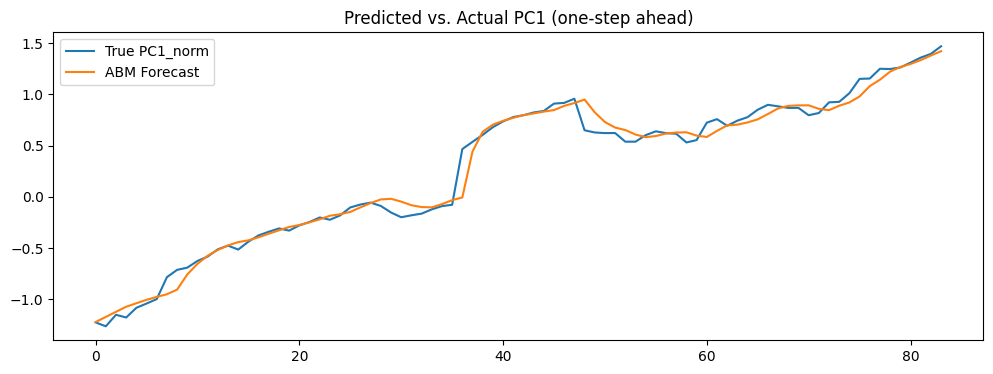

In [20]:
#@title PC1 forcast line plot
plt.figure(figsize=(12,4))
plt.plot(pc1_t, label="True PC1_norm")
plt.plot(pc1_p, label="ABM Forecast")
plt.title("Predicted vs. Actual PC1 (one-step ahead)")
plt.legend(); plt.show()

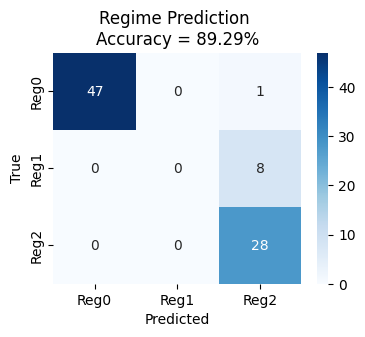

In [23]:
#@title Confusion matrix for regimes
cm = confusion_matrix(r_t, r_p, labels=[0,1,2])
acc = accuracy_score(r_t, r_p)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Reg0","Reg1","Reg2"],
            yticklabels=["Reg0","Reg1","Reg2"])
plt.title(f"Regime Prediction \nAccuracy = {acc:.2%}")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.show()

The differentiable ABM achieves a regime classification accuracy of 89.29%, with perfect identification of Regime 2 and near-perfect performance on Regime 0. However, the model struggles to recognize Regime 1 - the stagnation regime -, misclassifying all of its instances as Regime 2 - the recovery regime. This likely reflects either the small number of Regime 1 samples or the transitional nature of Regime 1, making it harder to distinguish from Regime 2 in terms of feature representation. Nonetheless, the high accuracy for Regimes 0 and 2 suggests that the model effectively captures the defining macro characteristics of contractionary and expansionary periods.

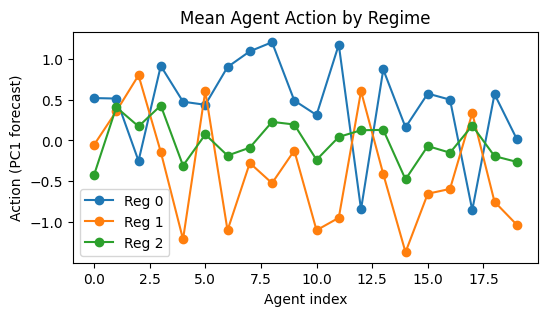

In [25]:
#@title Average action of each agent within each regime
acts_arr = np.stack(acts, axis=0)
regimes  = r_t

mean_by_reg = {}
for reg in [0,1,2]:
    mean_by_reg[reg] = acts_arr[regimes==reg].mean(axis=0)

plt.figure(figsize=(6,3))
for reg, col in zip([0,1,2], ["tab:blue","tab:orange","tab:green"]):
    plt.plot(mean_by_reg[reg], label=f"Reg {reg}", color=col, marker='o')
plt.title("Mean Agent Action by Regime")
plt.xlabel("Agent index"); plt.ylabel("Action (PC1 forecast)")
plt.legend(); plt.show()

This plot shows how each agent’s average action (interpreted as a one-step-ahead forecast of the macro factor PC1) varies across the three identified regimes.

In Regime 0 — associated with macroeconomic expansion — agents generally forecast higher PC1 values, reflecting optimism and confidence in continued positive trends.

In contrast, during Regime 1 — linked to macro stagnation or contraction — agents predict significantly lower values of PC1, suggesting a collective anticipation of weaker macro conditions.

Regime 2, the transition phase, exhibits moderate and more heterogeneous forecasts, indicating uncertainty or mixed expectations among agents.

Thus, the agents have learned to respond distinctly to different macro environments, validating the differentiable ABM's capacity to encode regime-aware expectations.

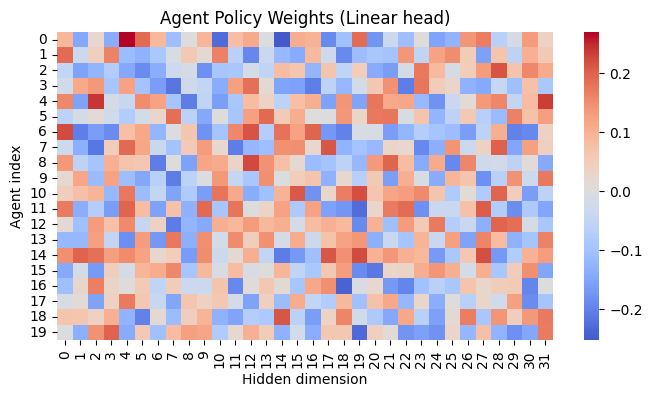

In [28]:
#@title Agent Policy Weights

weights = [ag.policy.weight.squeeze().detach().cpu().numpy()
           for ag in model.agents]
weights = np.stack(weights)

plt.figure(figsize=(8,4))
sns.heatmap(weights, cmap="coolwarm", center=0)
plt.title("Agent Policy Weights (Linear head)")
plt.xlabel("Hidden dimension"); plt.ylabel("Agent index")
plt.show()

The agent policy weight heatmap reveals substantial heterogeneity in how each agent maps its internal hidden state to macroeconomic actions. Some agents exhibit strong positive or negative weights on specific hidden dimensions, while others show more diffuse or neutral patterns. This diversity suggests that agents have developed distinct forecasting heuristics to different latent signals over training. The presence of structured variation across both agents and hidden units supports the view that the model is successfully learning a rich ensemble of behaviors, potentially useful for capturing different economic reactions across macro regimes.